In [70]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
import networkx as nx
import os
from sklearn.metrics import mean_squared_error
from pygsp import graphs

from IPython.display import display, clear_output
%matplotlib inline

In [2]:
DATA_PATH = '../data/ml-100k-convert/'
os.getcwd()

'/home/ng/MovieRecommendation/src'

In [3]:
# Load data
lens_ratings = pd.read_csv(DATA_PATH+'data.tsv', sep='\t', names=['UserId', 'MovieId', 'Ratings', 'Timestamp'])
print(lens_ratings.shape)
# Get rid of timestamp
lens_ratings = lens_ratings.drop(columns=['Timestamp'])
lens_ratings.head()

(100000, 4)


,UserId,MovieId,Ratings
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
nb_users = len(lens_ratings.UserId.unique())
nb_movies = len(lens_ratings.MovieId.unique())
print('There are {} users'.format(nb_users))
print('There are {} movies'.format(nb_movies))

There are 943 users
There are 1682 movies


In [5]:
# Pivot the table, put 0 when there are no ratings
ratings = pd.pivot_table(lens_ratings, index='UserId', columns='MovieId', values='Ratings', fill_value=0)
ratings

MovieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserId,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,0,4,5,3,0,...,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mask = np.random.rand(*ratings.shape) < 0.7
ratings_np = ratings.to_numpy()
rating_train = ratings_np.copy()
rating_test = ratings_np.copy()
rating_train[~mask] = 0
rating_test[mask] = 0
mask.shape

(943, 1682)

What is the distrubition of movies rated by a user?
as well as the maximum and minimum ratings:

Number of movies rated per user: mean: 106.0, max: 20, min: 737


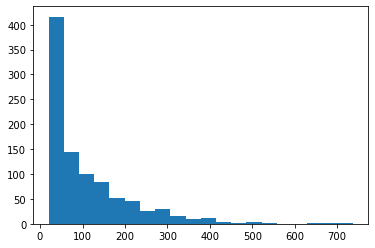

In [7]:
plt.hist(np.count_nonzero(ratings, axis=1),bins=20)
cnt = np.count_nonzero(ratings, axis=1)
print(f'Number of movies rated per user: mean: {cnt.mean():.1f}, max: {cnt.min()}, min: {cnt.max()}')

We want to normalize the ratings of the user by their indiviual average ratings

average rating by user before normalizazion


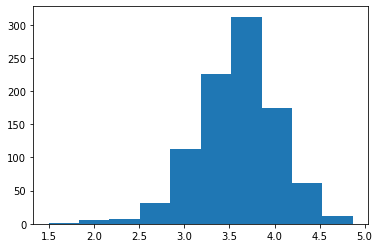

array([[1.38492872, 0.83095723, 1.10794297, ..., 0.        , 0.        ,
        0.        ],
       [1.07826087, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.23595506, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.46596859, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [8]:
average_rating = np.sum(ratings, axis = 1) / np.count_nonzero(ratings, axis=1)

print('average rating by user before normalizazion')
plt.hist(average_rating)
plt.show()
      
ratings_norm = ratings / average_rating[:,None]
ratings_norm = ratings_norm.to_numpy()
ratings_norm

get the range of movie ratings

In [9]:
print(f'Movie ratings: mean: {ratings_norm[ratings_norm.nonzero()].mean():0.1f}, max: {ratings_norm.min()}, min: {ratings_norm.max()}')
np.mean([])

Movie ratings: mean: 1.0, max: 0.0, min: 3.3513097072419105


/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [10]:
def user_distance(ratingsA, ratingsB):
    #print(len(ratingsA),len(ratingsB))
    diff_ratings = []
    n = 0
    for x, y in zip(ratingsA, ratingsB):
        if x != 0 and y != 0:
            n += 1
            diff_ratings.append((x - y)**2)
    if diff_ratings:
        return np.mean(diff_ratings) / n
    else:
        return np.inf
    
def user_distance2(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = ((ratingsA[mask] - ratingsB[mask])**2)
    if diff_ratings.shape[0] > 0:
        cA = np.count_nonzero(ratingsA)
        cB = np.count_nonzero(ratingsB)
        #print(cA, cB, min(cA, cB))
        return np.mean(diff_ratings) + 1 * (1 / diff_ratings.shape[0]) ** 2 + 0.6 * (np.abs(cA - cB) / min(cA, cB))**2.
    else:
        return np.inf
    
def user_weight_simple(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = np.abs((ratingsA[mask] - ratingsB[mask]))
    return np.sum(4 - diff_ratings) / (np.count_nonzero(ratingsA))

def count_intersect(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = np.abs((ratingsA[mask] - ratingsB[mask]))
    return diff_ratings.shape[0]

In [11]:
#weight_matrix = squareform(pdist(ratings_norm, user_weight_simple))
ratings_sample = ([[0,1,5,0,3,1,0],[3,3,3,3,0,0,0],[0,5,1,0,1,4,0],[4,5,1,0,0,5,0]])
pd.DataFrame(ratings_sample)

,0,1,2,3,4,5,6
0,0,1,5,0,3,1,0
1,3,3,3,3,0,0,0
2,0,5,1,0,1,4,0
3,4,5,1,0,0,5,0


In [12]:
#weight_matrix = squareform(pdist(ratings_test, user_weight_simple))
weight_matrix = (cdist(rating_train, rating_train, user_weight_simple))
np.fill_diagonal(weight_matrix,0)

In [13]:
print(np.min(weight_matrix), np.max(weight_matrix), np.mean(weight_matrix))
pd.DataFrame(weight_matrix)

0.0 3.3636363636363638 0.41220324601197605


,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,0.000000,0.212766,0.074468,0.037234,0.648936,0.765957,1.148936,0.223404,0.058511,0.590426,...,0.707447,0.101064,0.382979,0.175532,0.303191,0.127660,0.457447,0.074468,0.196809,0.494681
1,0.869565,0.000000,0.173913,0.282609,0.239130,0.934783,0.673913,0.086957,0.260870,0.391304,...,0.739130,0.500000,1.086957,0.565217,0.782609,0.369565,0.521739,0.282609,0.347826,0.326087
2,0.341463,0.195122,0.000000,0.219512,0.073171,0.463415,0.536585,0.195122,0.048780,0.341463,...,0.048780,0.000000,0.463415,0.268293,0.268293,0.024390,0.512195,0.170732,0.121951,0.097561
3,0.388889,0.722222,0.500000,0.000000,0.222222,0.444444,1.277778,0.722222,0.388889,0.111111,...,0.222222,0.000000,0.500000,0.166667,0.888889,0.166667,0.722222,0.500000,0.944444,0.722222
4,0.953125,0.085938,0.023438,0.031250,0.000000,0.500000,1.125000,0.156250,0.007812,0.382812,...,0.632812,0.062500,0.117188,0.070312,0.242188,0.062500,0.312500,0.062500,0.117188,0.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.685714,0.485714,0.028571,0.085714,0.228571,0.400000,0.742857,0.085714,0.114286,0.114286,...,0.371429,0.600000,0.828571,0.514286,1.000000,0.000000,0.285714,0.428571,0.171429,0.628571
939,1.023810,0.285714,0.250000,0.154762,0.476190,1.059524,1.297619,0.345238,0.178571,0.928571,...,1.023810,0.119048,0.440476,0.238095,0.345238,0.119048,0.000000,0.190476,0.488095,0.452381
940,0.823529,0.764706,0.411765,0.529412,0.470588,0.235294,1.058824,0.176471,0.705882,0.588235,...,0.235294,0.294118,1.882353,0.529412,1.411765,0.882353,0.941176,0.000000,0.588235,0.352941
941,0.637931,0.275862,0.086207,0.293103,0.258621,0.862069,1.775862,0.362069,0.189655,0.862069,...,1.000000,0.155172,0.206897,0.068966,0.344828,0.103448,0.706897,0.172414,0.000000,0.379310


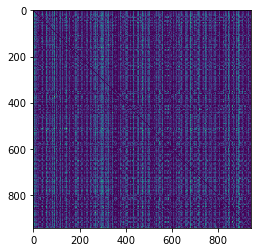

In [14]:
plt.imshow(weight_matrix)
plt.show()

(array([3.97502e+05, 2.16019e+05, 1.14575e+05, 5.02150e+04, 1.92690e+04,
        5.67800e+03, 1.19600e+03, 1.91000e+02, 3.40000e+01, 3.00000e+00]),
 array([2.02839757e-03, 3.38189194e-01, 6.74349991e-01, 1.01051079e+00,
        1.34667158e+00, 1.68283238e+00, 2.01899318e+00, 2.35515397e+00,
        2.69131477e+00, 3.02747557e+00, 3.36363636e+00]),
 <a list of 10 Patch objects>)

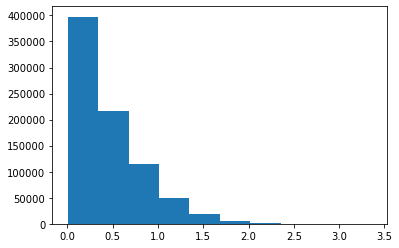

In [15]:
plt.hist(weight_matrix[weight_matrix > 0].flatten())

In [16]:
def epsilon_kernel(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): distance matrix
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    adjacency = np.exp( - X / (2 * (sigma ** 2)))
    adjacency[adjacency < epsilon] = 0
    np.fill_diagonal(adjacency, 0)
    return adjacency

In [17]:
i_user = 12
variance = 900

#ratings_np = ratings_np[:variance,:]
ratings_np.shape
rating_mask = (ratings_np != 0).astype(float)

def predictRating(user_corr, ratings ):
    rating_mask = (ratings != 0).astype(float)
    #user_corr = np.random.rand(user_corr.shape[0])
    #user_corr = np.random.rand(user_corr.shape[0])
    user_corr = user_corr
    #user_corr[user_corr == 4] = 0
    #np.kron(user_corr[:4])
    #user_corr[:4].shape)
    user_corr_expand = (np.ones((ratings.shape[1],1)) @ (user_corr.reshape((1,user_corr.shape[0])))).T * rating_mask 
    user_corr_exp_norm = user_corr_expand / (user_corr_expand.sum(axis=0)[np.newaxis, :] + 1E-10)
    user_corr_exp_norm[np.isnan(user_corr_exp_norm)] = 0
    weighted_ratings = ratings * user_corr_exp_norm
    pred_ratings = weighted_ratings.sum(axis = 0)
    return pred_ratings

pred_ratings = predictRating(weight_matrix[i_user,:].copy(), ratings_np)

In [18]:
pd.DataFrame(pred_ratings).head()

,0
0,3.889806
1,3.198890
2,3.012478
3,3.557591
4,3.240714


(array([  4.,  68.,  37.,  97., 190., 381., 405., 369., 117.,  14.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

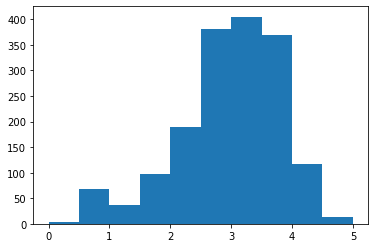

In [19]:
plt.hist(pred_ratings)

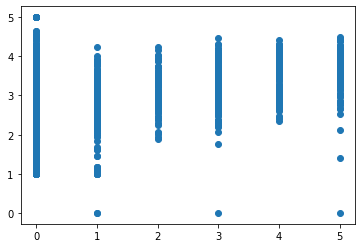

In [20]:
plt.scatter(ratings_np[i_user,:],pred_ratings)
plt.show()


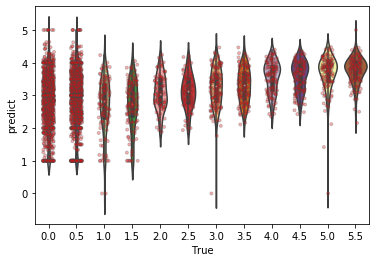

In [21]:
ratings_user = ratings_np[i_user,:]
mean_counter = ratings_np.copy().astype('float')
mean_counter[mean_counter == 0] = np.nan
mean_ratings = np.nanmean(mean_counter, axis = 0)
df1 = pd.DataFrame({ 'True' :ratings_np[i_user,:], 'predict' : pred_ratings})
df2 = pd.DataFrame({ 'True' : ratings_np[i_user,:] + 0.5, 'predict' : mean_ratings})
df = pd.concat([df1, df2])


sns.violinplot(x='True', y='predict', data=df, palette='Paired') #,split=True)
sns.stripplot(x='True', y='predict', data=df, color="red",jitter=0.2,dodge=True, size=3, alpha=0.3,linewidth=1)

In [22]:
ratings_np[ratings_np < 0]

array([], dtype=int64)

In [23]:
error = np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], pred_ratings[ratings_user != 0]))
error_avg = np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], mean_ratings[ratings_user != 0]))
print(error, error_avg, np.count_nonzero(ratings_user != 0))

1.2472926392677832 1.1956220934186141 636


In [43]:
errors = []
pred_ratings = np.zeros(ratings_np.shape)
for ii in range(weight_matrix.shape[0]):
    pred_rating = predictRating(weight_matrix[ii,:].copy(), rating_train)
    pred_ratings[ii,:] = pred_rating
    #pred_rating = predictRating(np.random.rand(nn_weight_mat.shape[0]), ratings_np)
    ratings_user = rating_test[ii,:]
    errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], np.round(pred_rating[ratings_user != 0]))))
    #errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0],(1+ 4 * np.random.rand(np.count_nonzero(ratings_user))))))
    if ii % 10 == 0:
        clear_output(wait=True)
        display(ii,np.average(errors))
#     if ii % 5 == 0:
#         #clear_output(wait=True)
#         line1.set_xdata(range(len(errors)))
#         line1.set_ydata(errors)
#         fig.canvas.draw()
#         fig.canvas.flush_events()
#         #plt.plot(errors)
#         plt.show()

940

1.0441753894893344

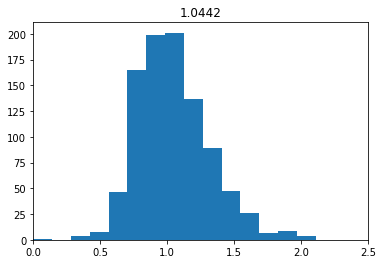

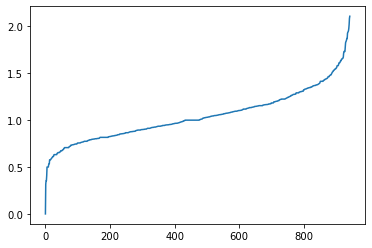

In [53]:
plt.hist(sorted(errors), bins=15)
plt.title(f'{np.average(errors):.4f}')
plt.xlim(0,2.5)
plt.show()
plt.plot(sorted(errors))
plt.show()

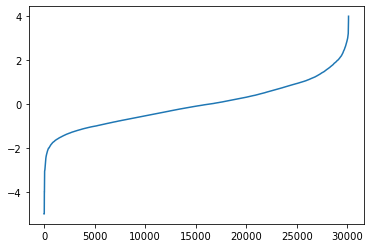

In [76]:
plt.plot(sorted(pred_ratings[rating_test != 0] - rating_test[rating_test != 0]))

In [63]:
ratings2 = pred_ratings.copy()
ratings2[rating_train != 0] = 0
ratings2 += rating_train

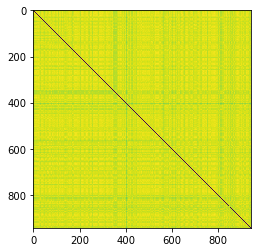

In [64]:
weight_matrix2 = squareform(pdist(ratings2, user_weight_simple))
np.fill_diagonal(weight_matrix2,0)
plt.imshow(weight_matrix2)

In [65]:
errors2 = []
pred_ratings2 = np.zeros(ratings_np.shape)
for ii in range(weight_matrix.shape[0]):
    pred_rating2 = predictRating(weight_matrix2[ii,:].copy(), rating_train)
    pred_ratings2[ii,:] = pred_rating2
    #pred_rating = predictRating(np.random.rand(nn_weight_mat.shape[0]), ratings_np)
    ratings_user = rating_test[ii,:]
    errors2.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], np.round(pred_rating2[ratings_user != 0]))))
    #errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0],(1+ 4 * np.random.rand(np.count_nonzero(ratings_user))))))
    if ii % 10 == 0:
        clear_output(wait=True)
        display(ii,np.average(errors2))

940

1.042962423589956

In [67]:
graph = nx.read_gexf('../generated/movie_genre_dense.gexf')
adjacency = nx.to_numpy_matrix(graph)

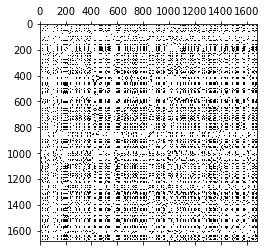

In [68]:
plt.spy(adjacency)

In [71]:
G = graphs.Graph(adjacency)
G.set_coordinates()
G.compute_laplacian('normalized')
G.compute_fourier_basis()

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


In [159]:
user = 1
signal = ratings2[user].copy()
mask = rating_train[user] != 0
val = (rating_test[user].copy()).astype(float)
val_mask = val != 0
val[~val_mask] = np.nan
signal, val

(array([4.        , 3.33076477, 2.74973043, ..., 2.        , 3.        ,
        3.        ]), array([nan, nan, nan, ..., nan, nan, nan]))

In [103]:
fouriersig = G.gft(signal)
fouriersig

array([107.16189761,   3.69713061,   9.57815095, ...,  -0.12395308,
         0.68297017,   2.28291705])

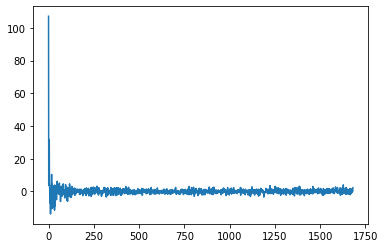

In [104]:
plt.plot(fouriersig)

In [105]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    vander = np.vander(lam, order+1)
    return np.linalg.lstsq(vander, spectral_response)[0]

def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    vander = np.vander(lam, len(coeff))
    return vander @ coeff

def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    laplacian_poly = 0
    for i, coef in enumerate(coeff):
        deg = len(coeff) - i - 1
        laplacian_poly += coef * np.linalg.matrix_power(laplacian, deg)
    return laplacian_poly

In [106]:
ideal_lp = np.ones((G.n_vertices,))
ideal_lp[G.e < 1.005] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_lp[G.e > 1.6] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_filter = ideal_lp# Store your spectral response here

AttributeError: 'Graph' object has no attribute 'n_vertices'

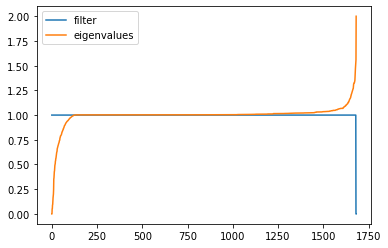

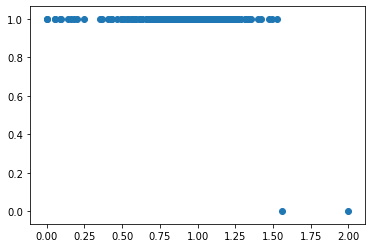

In [192]:
#alpha = 0.99 / np.max(G.e)

#ideal_filter =  1/(1 + alpha*G.e)
ideal_filter = np.ones(G.e.shape)
#ideal_filter[G.e < 0.1] = 0
ideal_filter[G.e > 1.55] = 0
plt.plot(ideal_filter, label = 'filter')
plt.plot(G.e, label = 'eigenvalues')
plt.legend()
plt.show()
plt.scatter(G.e, ideal_filter)
plt.show()

In [186]:
order =  4

coeff = fit_polynomial(G.e, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, G.L.A)

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


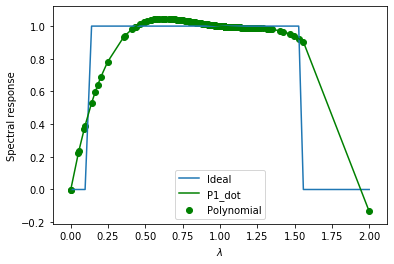

In [187]:
plt.plot(G.e, ideal_filter)
plt.scatter(G.e, polynomial_graph_filter_response(coeff, G.e),color='green')
# plt.yl
plt.plot(G.e, polynomial_graph_filter_response(coeff, G.e),'g')
plt.legend(['Ideal','P1_dot', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.show()

In [188]:
graph_gcn_filter = polynomial_graph_filter(coeff, G.L.A)

In [189]:
signal_filtered = (graph_gcn_filter) @ signal
signal_filtered_val = signal_filtered.copy()
signal_filtered_val[~val_mask] = np.nan

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


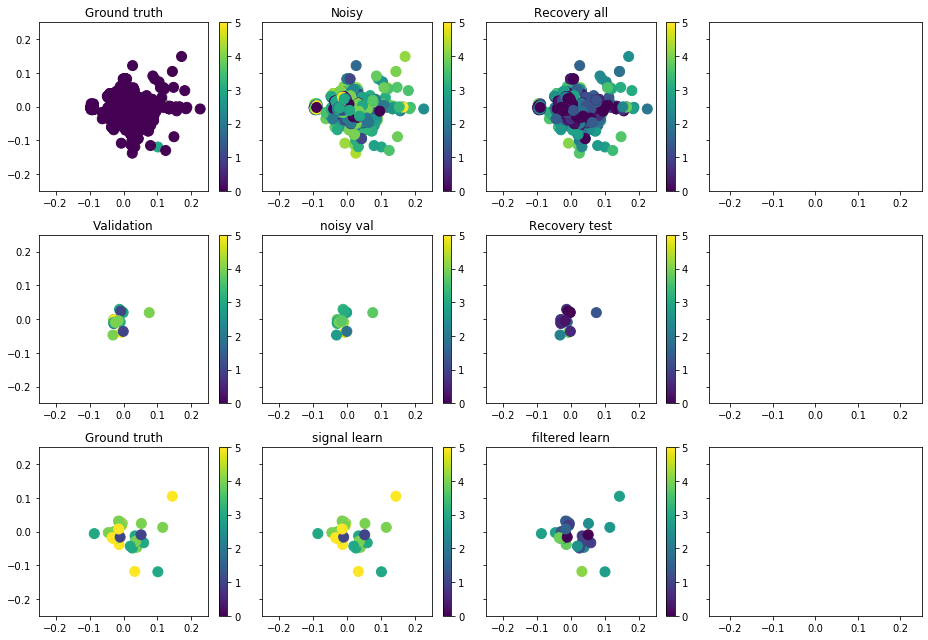

In [190]:
fig, ax = plt.subplots(3, 4, sharey=True, figsize=(13, 9))
limits = [signal.min(), signal.max()]
_ = G.plot_signal(ratings_np[user], ax=ax[0,0], limits=limits, plot_name='Ground truth')

_ = G.plot_signal(signal, ax=ax[0,1], limits=limits, plot_name='Noisy')
signal_red = signal.copy()
signal_red[~val_mask] = np.nan
_ = G.plot_signal(signal_red, ax = ax[1,1], limits = limits, plot_name = 'noisy val')
_ = G.plot_signal(val, ax=ax[1,0], limits=limits, plot_name='Validation', show_edges=False)
_ = G.plot_signal(signal_filtered, ax=ax[0,2], limits=limits, plot_name='Recovery all')
_ = G.plot_signal(signal_filtered_val, ax=ax[1,2], limits=limits, plot_name='Recovery test')

ground_train = ratings_np[user].copy().astype(float)
signal_train = signal.copy()
filtered_train = signal_filtered.copy()
ground_train[~mask] = np.nan
signal_train[~mask] = np.nan
filtered_train[~mask] = np.nan
_ = G.plot_signal(ground_train, ax=ax[2,0], limits=limits, plot_name='Ground truth')
_ = G.plot_signal(signal_train, ax=ax[2,1], limits=limits, plot_name='signal learn')
_ = G.plot_signal(filtered_train, ax=ax[2,2], limits=limits, plot_name='filtered learn')
for i,av in enumerate(ax):
    for j, v in enumerate(av):
        ax[i,j].set_ylim([-0.25,0.25])
        ax[i,j].set_xlim([-0.25,0.25])
_ = fig.tight_layout()

In [191]:
print(np.sqrt(mean_squared_error(val[val_mask], signal[val_mask])),
np.sqrt(mean_squared_error(val[val_mask], signal_filtered[val_mask])))

0.9173854964134345 2.6798901895892
